Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Initialize dataset
# I've curated this dataset and am hosting it,
# so sometimes I'll update the original file
# (this current version of the data, for example,
# has every column standardized)

import pandas as pd
df0 = pd.read_csv('https://socratesdidnothingwrong.com/nfl/qbcf/games.txt')

In [4]:
# Perform dimensionality reduction
from sklearn.decomposition import PCA
reducer = PCA(n_components=3, random_state=143)
hrmm = reducer.fit_transform(df0[df0.columns.drop('player')])
df1 = pd.DataFrame(hrmm, columns=['pca0', 'pca1', 'pca2'])
df1['player'] = df0['player']
df1 = df1[['player', 'pca0', 'pca1', 'pca2']]
print(df1.shape)
df1.head()

(8723, 4)


,player,pca0,pca1,pca2
0,Geno Smith,-2.758995,-0.861308,1.385933
1,Ryan Tannehill,0.707247,0.778092,-0.832187
2,Brandon Weeden,0.234863,-0.193391,-0.029960
3,Joe Flacco,0.514200,0.074003,0.331315
4,Matt Flynn,-2.359384,-0.665541,-0.062287


In [0]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(
    df1,
    test_size=0.2,
    random_state=143,
    stratify=df1['player']
)

y_col = 'player'
X_cols = df_train.columns.drop(y_col)

X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[y_col]
y_test = df_test[y_col]

In [7]:
# majority baseline
from sklearn.dummy import DummyClassifier
model_maj = DummyClassifier(strategy='most_frequent')
model_maj.fit(X_train, y_train)
model_maj.score(X_test, y_test)

0.03037249283667622

In [8]:
# "actual" model
from sklearn.ensemble import RandomForestClassifier

model_rfc = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    n_jobs=-1,
    random_state=143
)

model_rfc.fit(X_train, y_train)
model_rfc.score(X_test, y_test)

0.05845272206303725

# TOWARDS A PARTIAL DEPENDENCY PLOT

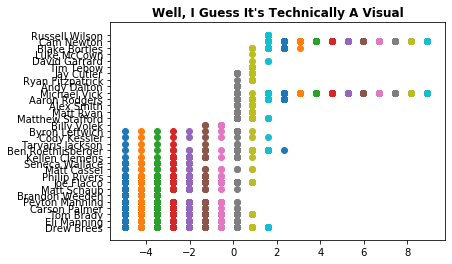

In [20]:
import numpy as np
import matplotlib.pyplot as plt
pca1s = np.linspace(-4.95, 8.9, 20)
for pca1 in pca1s:
  val = X_train.copy()
  val['pca1'] = [pca1] * X_train.shape[0]
  preds = model_rfc.predict(val)
  plt.scatter(val['pca1'], preds)
plt.title('Well, I Guess It\'s Technically A Visual', fontweight='bold')
plt.show()

(<Figure size 1080x36720 with 137 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f01c173a160>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f01c1d6ac88>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


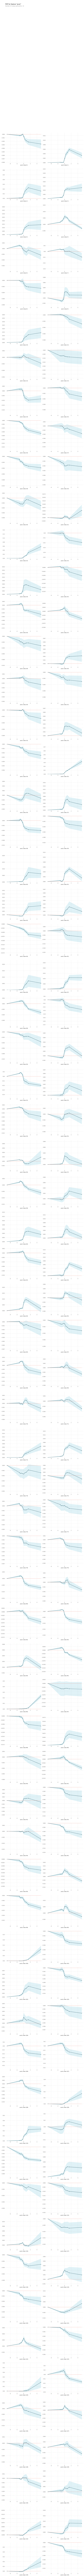

In [23]:
from pdpbox.pdp import pdp_isolate, pdp_plot
isolated = pdp_isolate(
    model=model_rfc,
    dataset=X_train,
    model_features=X_train.columns,
    feature='pca1'
)

# one for each class :/
# again, technically an answer
pdp_plot(isolated, feature_name='pca1');